# ARIMA MODEL 


##### Step 1. Import modules and load dataset

In [1]:
#Import required Libraries
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('HPG Historical Data.csv',delimiter=",", thousands=',')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,28600.0,28400.0,28800.0,28050.0,17.74M,1.24%
1,05/30/2024,28250.0,28500.0,28550.0,28000.0,27.26M,-1.22%
2,05/29/2024,28600.0,29100.0,29250.0,28600.0,21.60M,-1.89%
3,05/28/2024,29150.0,29000.0,29200.0,28800.0,17.56M,0.87%
4,05/27/2024,28900.0,28900.0,29300.0,28650.0,15.76M,0.00%
...,...,...,...,...,...,...,...
1308,03/07/2019,12001.1,12317.8,12335.4,12001.1,12.47M,-2.57%
1309,03/06/2019,12317.8,12317.8,12388.2,12106.6,9.24M,-0.14%
1310,03/05/2019,12335.4,12353.0,12529.0,12300.2,15.62M,-0.85%
1311,03/04/2019,12441.0,12229.8,12441.0,12212.2,13.74M,3.21%


In [3]:
# Determine the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1313 non-null   object 
 1   Price     1313 non-null   float64
 2   Open      1313 non-null   float64
 3   High      1313 non-null   float64
 4   Low       1313 non-null   float64
 5   Vol.      1313 non-null   object 
 6   Change %  1313 non-null   object 
dtypes: float64(4), object(3)
memory usage: 71.9+ KB


In [4]:
# Convert data
df['Date'] = pd.to_datetime(df['Date'])

##### Step 2. Selecting attribute 

In [5]:
df = df[['Price']]
df = df.dropna() 
df = df.reset_index(drop=True) 
df

,Price
0,28600.0
1,28250.0
2,28600.0
3,29150.0
4,28900.0
...,...
1308,12001.1
1309,12317.8
1310,12335.4
1311,12441.0


##### Step 3. Split the dataset into train, test, validate

In [6]:
# Calculate the number of samples for each set
train_size = int(0.80 * len(df))
test_size = int(0.20 * len(df))

# Split data into sets
train_data = df[:train_size]
test_data = df[train_size:]

# Check the size of each set
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1050
Test data size: 263


##### Step 4. Process of training the model

In [7]:
#ADF test
r = adfuller(train_data, autolag='AIC', regression='ct')
print('ADF Statistic: {}'.format(r[0]))
print('p-value: {}'.format(r[1]))
print('Critical Values:')
for key, value in r[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.8933030911959056
p-value: 0.9568669435043669
Critical Values:
	1%: -3.9675521264097227
	5%: -3.4147445273860986
	10%: -3.1295542716349165


In [8]:
print('ADF Statistic for 1st Order Differencing')
result = adfuller(train_data.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for 1st Order Differencing
ADF Statistic: -6.874153
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


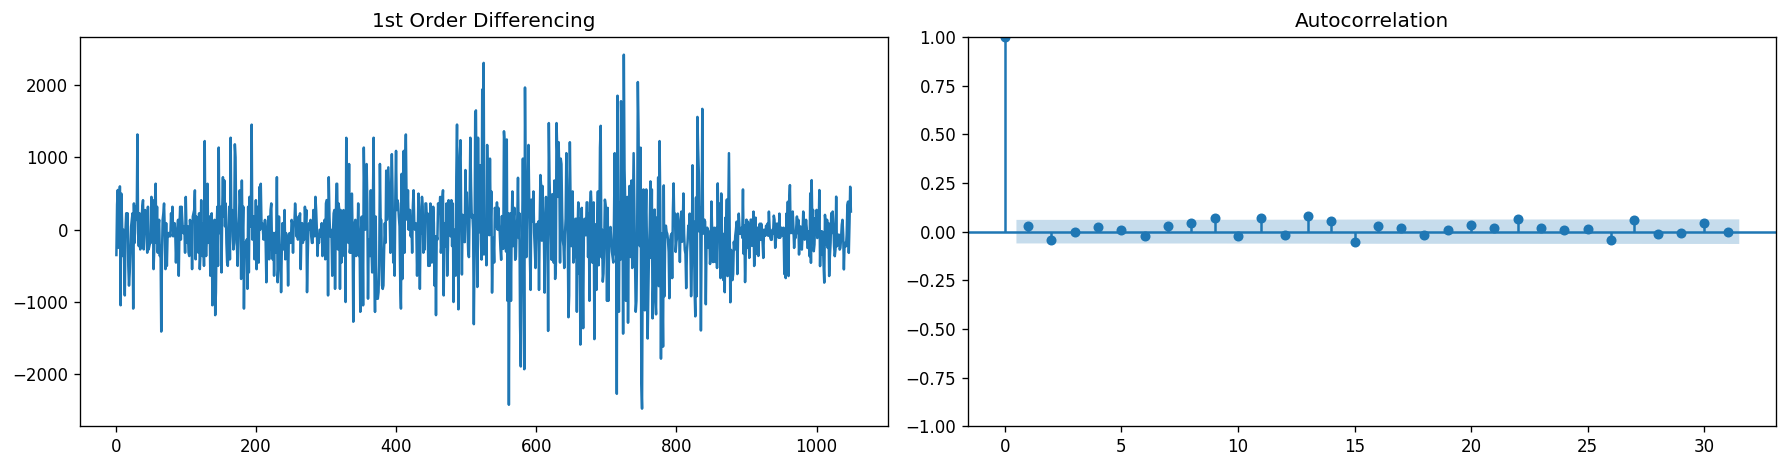

In [9]:
plt.rcParams.update({'figure.figsize': (15, 4), 'figure.dpi': 120})

# 1st Differencing
fig, ax = plt.subplots(1, 2)  # Create a figure with 1 row and 2 columns
ax[0].plot(train_data.diff()); ax[0].set_title('1st Order Differencing')
plot_acf(train_data.diff().dropna(), ax=ax[1])  # Use ax[1] for ACF plot

plt.tight_layout() 
plt.show()

In [10]:
!pip install pmdarima

In [11]:
# Process of Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train model
from pmdarima.arima import auto_arima
model = auto_arima(y_train, d=1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16247.125, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16248.759, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16248.733, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16246.333, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16247.925, Time=1.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.108 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
# Process of Testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

##### Step 5. Evaluate the accuracy of test sets

In [13]:
# RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('RMSE:', test_rmse)

# MAPE
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('MAPE:', mape_test)

# MAE
mae_test = np.mean(np.abs(y_test - y_pred))
print("MAE:", mae_test)

RMSE: 2008.1566491507872
MAPE: 17.359544567409575
MAE: 1885.3977186311786


##### Step 6. Forecasting 

In [14]:
# Process of creating an index to predict the next 90 days
last_index = df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Creating an array for the next 90 days
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Predicting the next 90 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

# Printing out the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5
 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5
 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5
 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5
 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5
 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5
 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5
 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5
 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5 8761.5]


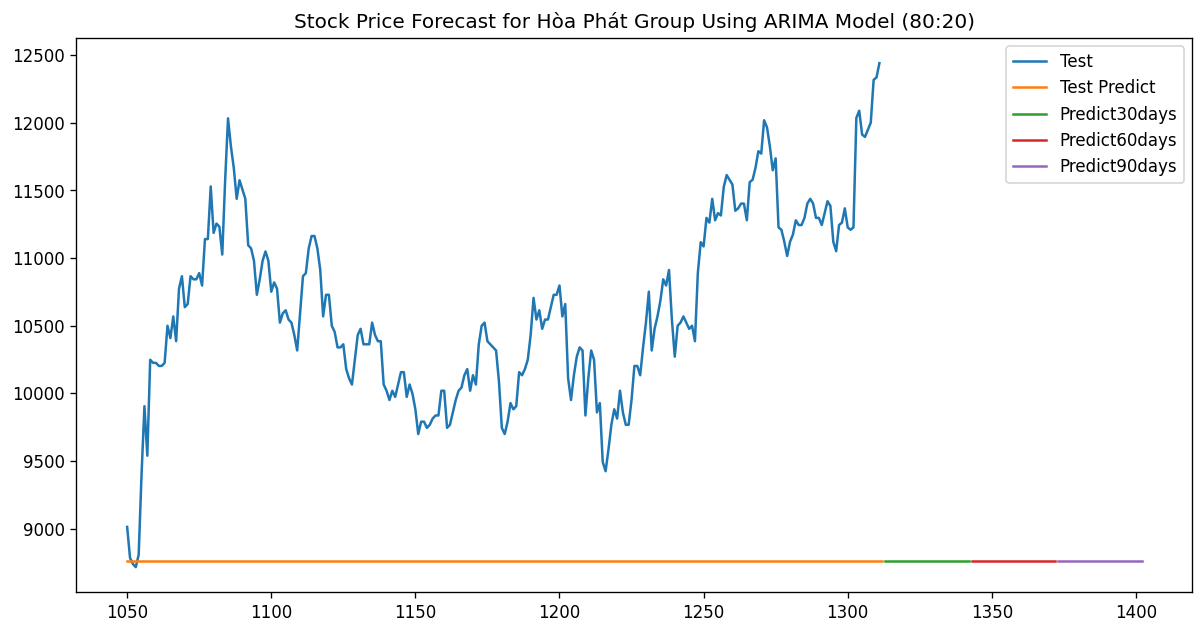

In [17]:
# Tạo DataFrame cho dự đoán test
test_predict_df = pd.DataFrame(y_pred, columns=['Price'])
test_predict_index = range(len(train_data), len(train_data)+ len(y_pred)) 
test_predict_df.index = test_predict_index

# Tạo DataFrame cho dữ liệu huấn luyện và kiểm tra
train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]

next_90_days_index = np.arange(len(df), len(df) + 90)
next_90_days_df = pd.DataFrame(y_next_90_days, index=next_90_days_index, columns=['Price'])

# Vẽ đồ thị
plt.figure(figsize=(12, 6))

# Vẽ dữ liệu kiểm tra
plt.plot(test_data_df, label='Actual Test')

# Vẽ dự báo test predict
plt.plot(test_predict_df.index, test_predict_df['Price'], label='Test Predict')

# Vẽ dự báo 

plt.plot(next_90_days_df.index[:30], next_90_days_df['Price'][:30], label='Next 30 days')
plt.plot(next_90_days_df.index[30:60], next_90_days_df['Price'][30:60], label='Next 60 days')
plt.plot(next_90_days_df.index[60:], next_90_days_df['Price'][60:], label='Next 90 days')

# Thêm chú thích và hiển thị đồ thị
plt.title('Stock Price Forecast for Hòa Phát Group Using ARIMA Model (80:20)')
plt.legend(['Test', 'Test Predict', 'Predict30days', 'Predict60days', 'Predict90days'])
plt.show()

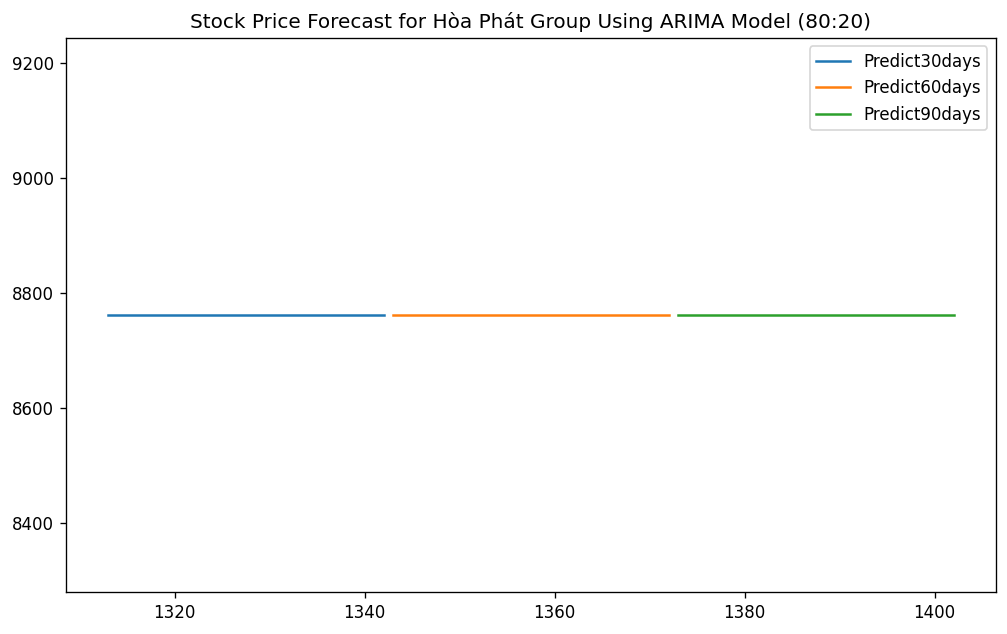

In [18]:
plt.figure(figsize=(10, 6))

plt.plot(next_90_days_df.index[:30], next_90_days_df['Price'][:30], label='Next 30 days')
plt.plot(next_90_days_df.index[30:60], next_90_days_df['Price'][30:60], label='Next 60 days')
plt.plot(next_90_days_df.index[60:], next_90_days_df['Price'][60:], label='Next 90 days')

plt.title('Stock Price Forecast for Hòa Phát Group Using ARIMA Model (80:20)')
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.show()